In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import gzip

import warnings
warnings.filterwarnings("ignore")

import io
from pysam import VariantFile

from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve, f1_score

from viz import *

In [2]:
context = 'talk' # talk or paper

if context == 'talk':
    sns.set(style="darkgrid", context="talk", rc={"lines.linewidth": 2, "legend.fontsize":25})
    plt.style.use("dark_background")
    plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5,'font.size': 30})
    sns.set_palette("deep")
else:
    sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 1, "legend.fontsize":10})
    plt.rcParams.update({'font.size': 15})
    sns.set_palette("deep")

lc = 'w' if context == 'talk' else 'k'

In [3]:
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
nmethods = len(methods)

In [4]:
tab20 = cm.get_cmap('tab10', 8)
newcmap_list = []
for i in range(4):
    newcmap_list.append(tab20.colors[i])
for i in range(4):
    newcmap_list.append(np.array(list(tab20.colors[i][:-1]) +[0.3]))

newcmap = ListedColormap(newcmap_list, name='newcmap')
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

In [5]:
dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855), (0.125, 0.875)]
alpha_list = [1, 1, .8, .6, .4, .2, 0.1]

# Select plasma sample and reference

In [6]:
#sample = '809'
patient = '986'
#sample = '1014'
#reference = 'pooledhealthy_986_filter_snv'
reference = 'pooledhealthy'
#reference = 'lowtb'

In [7]:
if patient == '809':
    plasmasample1 = 'CRC-809_110914'
    plasmasample2 = 'CRC-809_030915'
    tumorsample1 = 'NCC_CRC-809_290714-T1W'
elif patient == '986':
    plasmasample1 = 'CRC-986_100215'
    plasmasample2 = 'CRC-986_261016'
    tumorsample1 = 'NCC_CRC-986_100215-T1W'
elif patient == '1014':
    plasmasample1 = 'CRC-1014_180816'
    plasmasample2 = 'CRC-1014_110116'
    tumorsample1 = None

In [8]:
if reference == 'lowtb':
    if patient == '986':
        reference = 'CRC-986_300316'
    elif patient == '809':
        raise ValueError('no matched low tb sample')
    elif patient == '1014':
        reference = 'CRC-1014_090516'

print(reference) # pooledhealthy if not lowtb

pooledhealthy


In [9]:
dilutiondirpath = ["..","data","dilutions_chr22"]
bcbiooutputdirpath = ["..","data","bcbio_output"]
prefix = 'dilution_chr22_'
chrom = '22'

# Load SNV calls
## Calls of dilution series of first plasma sample

In [20]:
vcf_samples_dict, dilutionseries_new = load_calls_from_vcf_dilutionseries(bcbiooutputdirpath, plasmasample1, reference,
                                                                          dilutionseries, methods, prefix=prefix, chrom='all')

vcf_pd_0 (1, 0)
vcf_pd_1 (1, 0.72)


KeyboardInterrupt: 

In [22]:
vcf_samples_dict['sample_0']

,CHROM,POS,REF,ALT,QUAL,FILTER,type,freebayes,mutect2,strelka2,vardict,varscan,freebayes_score,mutect2_score,strelka2_score,vardict_score,varscan_score
CHROM_POS,,,,,,,,,,,,,,,,,
22_16060409,22,16060409,C,CCTCCCCAGTTTTTTTTTTAATGATACGGCGACCACCGAGATCTAC...,72.0,PASS,INS,False,False,False,True,False,0.0,0.0,0.0,0.27638,0.00
22_16060479,22,16060479,TTTTTTC,T,133.0,PASS,DEL,False,False,False,True,False,0.0,0.0,0.0,0.02700,0.00
22_16060509,22,16060509,CTT,C,243.0,PASS,DEL,True,False,False,False,False,0.0,0.0,0.0,0.00000,0.00
22_16060515,22,16060515,CTT,C,243.0,PASS,SNP,True,False,False,False,False,0.0,0.0,0.0,0.00000,0.00
22_16060573,22,16060573,CTTTCT,C,243.0,PASS,SNP,True,False,False,False,False,0.0,0.0,0.0,0.00000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22_51238461,22,51238461,T,C,0.0,PASS,SNV,False,False,False,False,True,0.0,0.0,0.0,0.00000,0.09
22_51239226,22,51239226,G,A,0.0,PASS,SNP,False,False,False,False,True,0.0,0.0,0.0,0.00000,0.07
22_51241240,22,51241240,T,C,0.0,PASS,SNV,False,False,False,False,True,0.0,0.0,0.0,0.00000,0.03


In [10]:
vcf_samples_dict, dilutionseries_new = load_calls_from_vcf_dilutionseries(bcbiooutputdirpath, plasmasample1, reference,
                                                                          dilutionseries, methods, prefix=prefix, chrom=chrom)

print(vcf_samples_dict.keys())
nsamples = len(vcf_samples_dict.keys())
samples = list(vcf_samples_dict.values())
vcf_samples_dict['sample_'+str(nsamples-1)].head()

vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
vcf_pd_3 (0.5, 0.81)
sample is not present with path ../data/bcbio_output/dilution_chr22_CRC-986_100215_0.5_pooledhealthy_0.81/dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
dilution (0.5, 0.81) is not present with path ../data/bcbio_output/dilution_chr22_CRC-986_100215_0.5_pooledhealthy_0.81/dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
vcf_pd_3 (0.25, 0.855)
select a single chrom = 22 for analysis
vcf_pd_4 (0.125, 0.875)
select a single chrom = 22 for analysis
dict_keys(['sample_0', 'sample_1', 'sample_2', 'sample_3', 'sample_4'])


,CHROM,POS,REF,ALT,QUAL,FILTER,type,freebayes,mutect2,strelka2,vardict,varscan,freebayes_score,mutect2_score,strelka2_score,vardict_score,varscan_score
CHROM_POS,,,,,,,,,,,,,,,,,
22_16050252,22,16050252,A,T,377.4,PASS,SNP,True,False,False,True,False,0.999994,0.0,0.0,0.00000,0.0
22_16050353,22,16050353,G,T,115.0,PASS,SNP,False,False,False,True,True,0.000000,0.0,0.0,0.65466,0.0
22_16050455,22,16050455,T,C,82.0,PASS,SNV,False,False,False,True,False,0.000000,0.0,0.0,0.73104,0.0
22_16050822,22,16050822,G,A,0.0,PASS,SNP,False,True,False,True,True,0.000000,1.0,0.0,0.00000,0.0
22_16050922,22,16050922,T,G,0.0,PASS,SNP,False,True,False,True,True,0.000000,1.0,0.0,0.00000,0.0


## Calls of second plasma sample

In [11]:
vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample2+"_1_pooledhealthy_0", prefix+plasmasample2+"_1_pooledhealthy_0-ensemble-annotated.vcf") 

if os.path.exists(vcf_path):
    vcf_samples_dict['sample_0_bis'] = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
    print(vcf_samples_dict.keys())
    l1 = list(vcf_samples_dict['sample_0'].index)
    l2 = list(vcf_samples_dict['sample_0_bis'].index)
    print(len(l1), len(l2))
    print(len(list(set(set(l1) & set(l2)))))
else:
    print("second plasma sample {} is not present with path {}".format(plasmasample2, vcf_path))

select a single chrom = 22 for analysis
dict_keys(['sample_0', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_0_bis'])
24729 18011
4368


# Calls of matched tumor

In [12]:
vcf_path = os.path.join(*bcbiooutputdirpath, tumorsample1, tumorsample1+"-ensemble-annotated.vcf") 

if os.path.exists(vcf_path):
    vcf_samples_dict['sample_t'] = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
    print(vcf_samples_dict.keys())
    l1 = list(vcf_samples_dict['sample_0'].index)
    l2 = list(vcf_samples_dict['sample_t'].index)
    print(len(l1), len(l2))
    print(len(list(set(set(l1) & set(l2)))))
else:
    print("tumor sample {} is not present with path {}".format(tumorsample1, vcf_path))

IndexError: list index out of range

# Estimated tumor burden of mixed samples

In [12]:
samples_tf = {}
for i in range(nsamples):
    samples_tf['sample_'+str(i)] = float(list(pd.read_csv(os.path.join(*dilutiondirpath,
        "estimated_tf_chr"+chrom+'_'+plasmasample1+"_"+str(dilutionseries_new[i][0])+"_"+reference+"_"+str(dilutionseries_new[i][1])+".txt")).columns)[0])
print(samples_tf)

{'sample_0': 0.41899930338493496, 'sample_1': 0.08332118791365564, 'sample_2': 0.06246857187258912, 'sample_3': 0.02080792450423319, 'sample_4': 0.01043106660067952}


# Depth of coverage of mixed samples

{'sample_0': [50.2097, 0.41899930338493496], 'sample_1': [338.854, 0.08332118791365564], 'sample_2': [344.346, 0.06246857187258912], 'sample_3': [355.321, 0.02080792450423319], 'sample_4': [357.07, 0.01043106660067952]}


,average depth of coverage,tumor burden
sample_0,50.2097,41.90
sample_1,338.8540,8.33
sample_2,344.3460,6.25
sample_3,355.3210,2.08
sample_4,357.0700,1.04


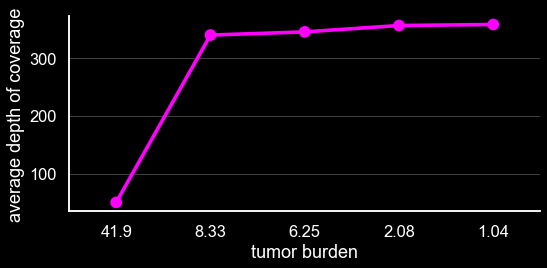

In [13]:
samples_cov = {}
for i in range(nsamples):
    samples_cov['sample_'+str(i)] = [float(list(pd.read_csv(os.path.join(*dilutiondirpath,
        "coverage_chr"+chrom+'_'+plasmasample1+"_"+str(dilutionseries_new[i][0])+"_"+reference+"_"+str(dilutionseries_new[i][1])+".txt")).columns)[0]),
                                     float(list(pd.read_csv(os.path.join(*dilutiondirpath,
        "estimated_tf_chr"+chrom+'_'+plasmasample1+"_"+str(dilutionseries_new[i][0])+"_"+reference+"_"+str(dilutionseries_new[i][1])+".txt")).columns)[0])]
print(samples_cov)

coverage_pd = pd.DataFrame.from_dict(samples_cov).T
coverage_pd.columns = ['average depth of coverage', 'tumor burden']
coverage_pd['tumor burden'] = 100*coverage_pd['tumor burden']
coverage_pd = coverage_pd.round({'tumor burden': 2}) 
sns.factorplot(x='tumor burden', y='average depth of coverage', data=coverage_pd,
            order=sorted(coverage_pd['tumor burden'].unique(), reverse=True), color='magenta', size=4, aspect=2)
        
coverage_pd

In [14]:
print(patient, reference, nsamples)

986 pooledhealthy 5


# Number of detections detected

In [15]:
numbersnvs_pd = count_mutations(samples, methods, samples_tf, mutationtypes=['all', 'INDEL', 'SNV', 'SNP'])
numbersnvs_pd

,freebayes,mutect2,strelka2,vardict,varscan
0.418999,1023,257,633,14107,10128
0.083321,25063,32621,35380,108175,99901
0.062469,25912,33282,36291,106493,100288
0.020808,27436,34032,37985,105481,100032
0.010431,27820,34275,38445,104494,100209


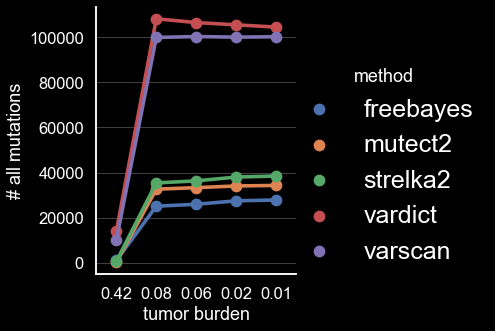

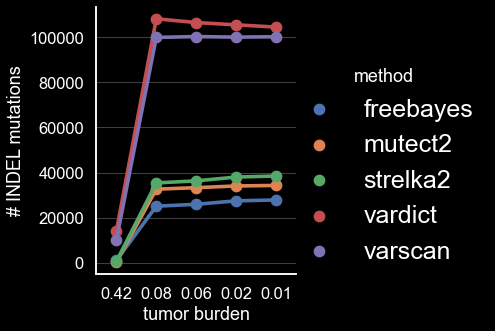

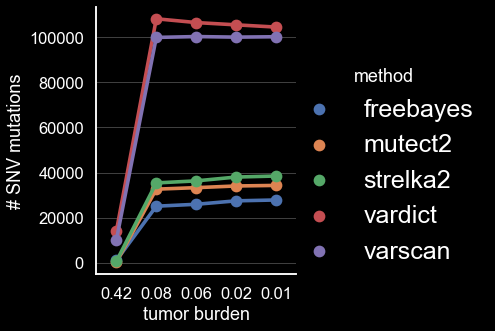

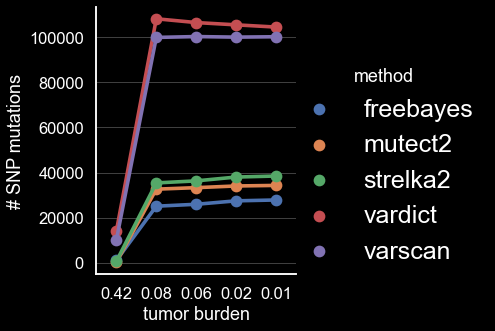

In [16]:
for mutationtype in ['all', 'INDEL', 'SNV', 'SNP']:
    numbersnvs_pd_aux = numbersnvs_pd.reset_index()
    numbersnvs_pd_aux = numbersnvs_pd_aux.rename(columns = {'index':'tumor burden'})
    numbersnvs_pd_aux = pd.melt(numbersnvs_pd_aux, id_vars=['tumor burden'], value_vars=methods, var_name='method', value_name='# '+ mutationtype +' mutations')
    numbersnvs_pd_aux = numbersnvs_pd_aux.rename(columns = {'index':'tumor burden'})
    numbersnvs_pd_aux = numbersnvs_pd_aux.round({'tumor burden': 2}) 
    sns.catplot(x='tumor burden', y='# '+ mutationtype +' mutations', kind='point', data=numbersnvs_pd_aux, hue='method',
               order=sorted(numbersnvs_pd_aux['tumor burden'].unique(), reverse=True), title=mutationtype)

# Within caller consistency with original Plasma Sample as reference

In [26]:
#vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample2+"_1_pooledhealthy_0", prefix+plasmasample2+"_1_pooledhealthy_0-ensemble-annotated.vcf") 
#res = read_vcf(vcf_path)
#res['callers'] = res['INFO'].apply(lambda x: pd.Series(x.split('CALLERS=')[1].split(';')[0]))
#for m in methods:
#    res[m] = res['INFO'].str.contains(m)
#sample = res[['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', *methods]]
#sample

In [27]:
#m = 'varscan'
#aux = [float(i.split('SSC=')[1].split(';')[0]) if 'SSC' in i else 0 for i in res['INFO']]
#auxr = sample['varscan'].values

#print([str(aux[i]) + str(auxr[i]) + '    ' for i in range(20)])

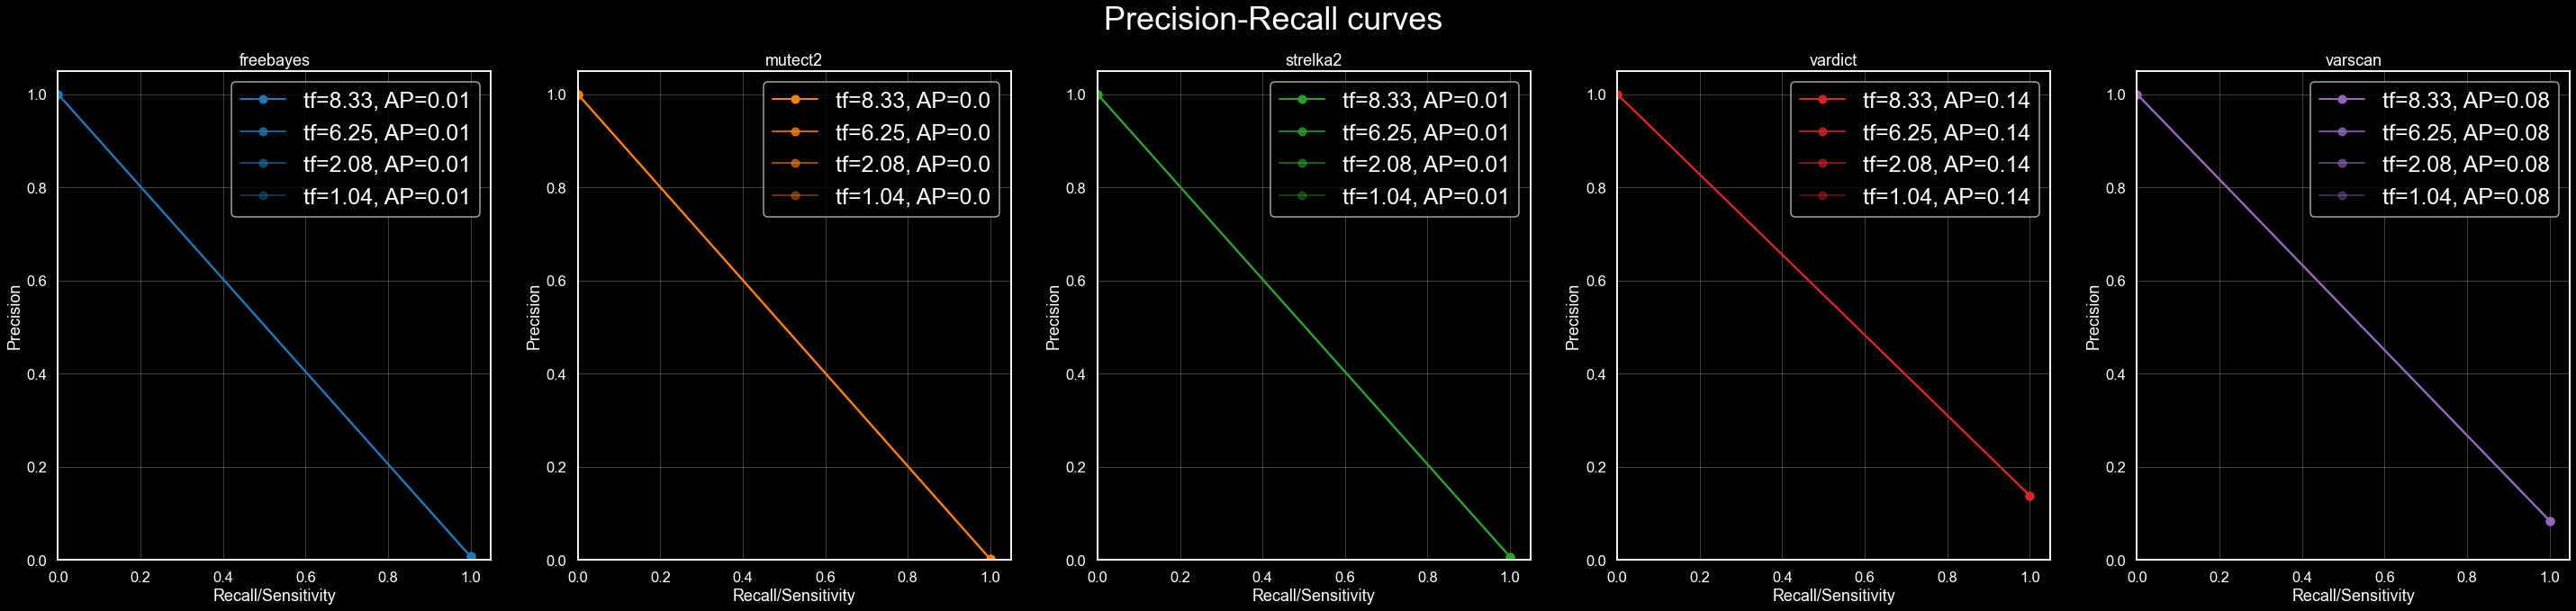

<Figure size 432x288 with 0 Axes>

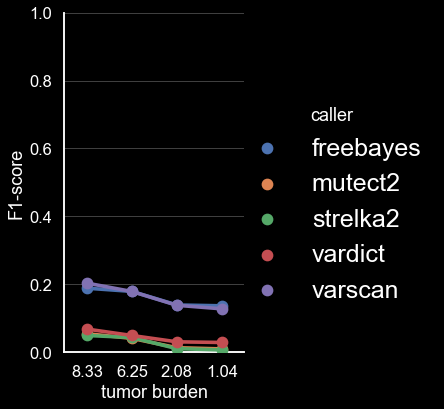

In [19]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            if i == 0:
                si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            else:
                si = sample[['QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace=True)
            slist.append(si)

        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(vcf_samples_dict.keys())[:nsamples]] = pd_method[list(vcf_samples_dict.keys())[:nsamples]]#.fillna(value=0)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == 0].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')

    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true_bool = pd_methods[pd_methods['caller'] == method]['sample_0'].fillna(value=False)
        y_true = y_true_bool.astype(int)

        for i in range(nsamples):
            y_i_bool = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].reindex(y_true.index).squeeze()
            y_i_bool = y_i_bool.fillna(False)
            y_list.append(y_i_bool)

        res_df['F1-score'] = [f1_score(y_true_bool, y_i_bool) for y_i_bool in y_list]  
        res_PR_df['precision'] = [precision_score(y_true_bool, y_i_bool) for y_i_bool in y_list]
        res_PR_df['recall'] = [recall_score(y_true_bool, y_i_bool) for y_i_bool in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method+'_score']['sample_'+str(i)].reindex(y_true.index).squeeze()
            y_i = y_i.fillna(0)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall/Sensitivity')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="F1-score", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.ylim([0, 1])

In [64]:
res = read_vcf(vcf_path)
res['callers'] = res['INFO'].apply(lambda x: pd.Series(x.split('CALLERS=')[1].split(';')[0]))
for m in methods:
    res[m] = res['INFO'].str.contains(m)
sample = res[['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', *methods]]
sample

,CHROM,POS,REF,ALT,QUAL,FILTER,freebayes,mutect2,strelka2,vardict,varscan
0,22,16050252,A,T,0.0,PASS,True,True,True,True,False
1,22,16060479,TTTTTTC,T,108.0,PASS,False,False,False,True,False
2,22,16060509,CTT,C,57.5,PASS,True,False,False,False,False
3,22,16060515,CTT,C,57.5,PASS,True,False,False,False,False
4,22,16061667,A,AT,0.0,PASS,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
18222,GL000236.1,7648,GA,G,0.0,PASS,False,False,False,False,True
18223,GL000236.1,8530,A,G,0.0,PASS,False,False,False,False,True
18224,GL000236.1,8635,G,T,0.0,PASS,False,False,False,False,True
18225,GL000217.1,3852,C,G,0.0,PASS,False,False,False,False,True


In [113]:
for m in methods:
    if m == 'vardict': # P-value
        sample[m] = [10**(-float(i.split('SSF=')[1].split(';')[0])/0.05) if 'SSF' in i else 0 for i in res['INFO']]
                # res['INFO'].apply(lambda x: pd.Series(x.split('SSF=')[1].split(';')[0]).astype(float) if 'SSF' in x else 0)
        ### efif m == 'varscan': # P-value
            #    sample[m] = [float(i.split('SSC=')[1].split(';')[0]) if 'SSC' in i else 0 for i in res['INFO']]
    #if m == 'mutect2': # logodds to probability score prob = exp(logODDS)/(1+exp(logODDS))
    #    sample[m] = [float(i.split('TLOD=')[1].split(';')[0])/(1+float(i.split('TLOD=')[1].split(';')[0])) if 'TLOD' in i else 0 for i in res['INFO']]
        # [float(i.split('TLOD=')[1].split(';')[0])  if 'TLOD' in i else 0 for i in res['INFO']]
                     #[np.exp(float(i.split('TLOD=')[1].split(';')[0]))/(1+np.exp(float(i.split('TLOD=')[1].split(';')[0]))) if 'TLOD' in i else 0 for i in res['INFO']]
    #if m == 'freebayes': # logodds to probability score prob = exp(logODDS)/(1+exp(logODDS))
    #    sample[m] = [float(i.split('ODDS=')[1].split(';')[0]) if 'ODDS' in i else 0 for i in res['INFO']]
        #[float(i.split('ODDS=')[1].split(';')[0])/(1+float(i.split('ODDS=')[1].split(';')[0])) if 'ODDS' in i else 0 for i in res['INFO']]
    #if m == 'strelka2': # phred score to probability, prob = 1 - 10^(-SomaticEVS/10)
    #    sample[m] = [1-10**(-float(i.split('SomaticEVS=')[1].split(';')[0])/10) if 'SomaticEVS' in i else 0 for i in res['INFO']]
        # sample[m] = [1-10**(-float(i.split('SomaticEVS=')[1].split(';')[0])/10) if 'SomaticEVS' in i else 0 for i in res['INFO']]

In [116]:
sample['vardict'][(sample['vardict'] > 0)]# & (sample['vardict'] > 0.0) ].values) #& (sample['vardict'] > 0.0) ].shape

1        1.183586e-01
14       2.209022e-02
21       2.621803e-05
129      5.818352e-04
144      5.807644e-04
             ...     
17958    1.221800e-10
17960    1.148154e-12
17967    2.452449e-09
17968    4.850651e-08
17970    9.311079e-10
Name: vardict, Length: 2085, dtype: float64

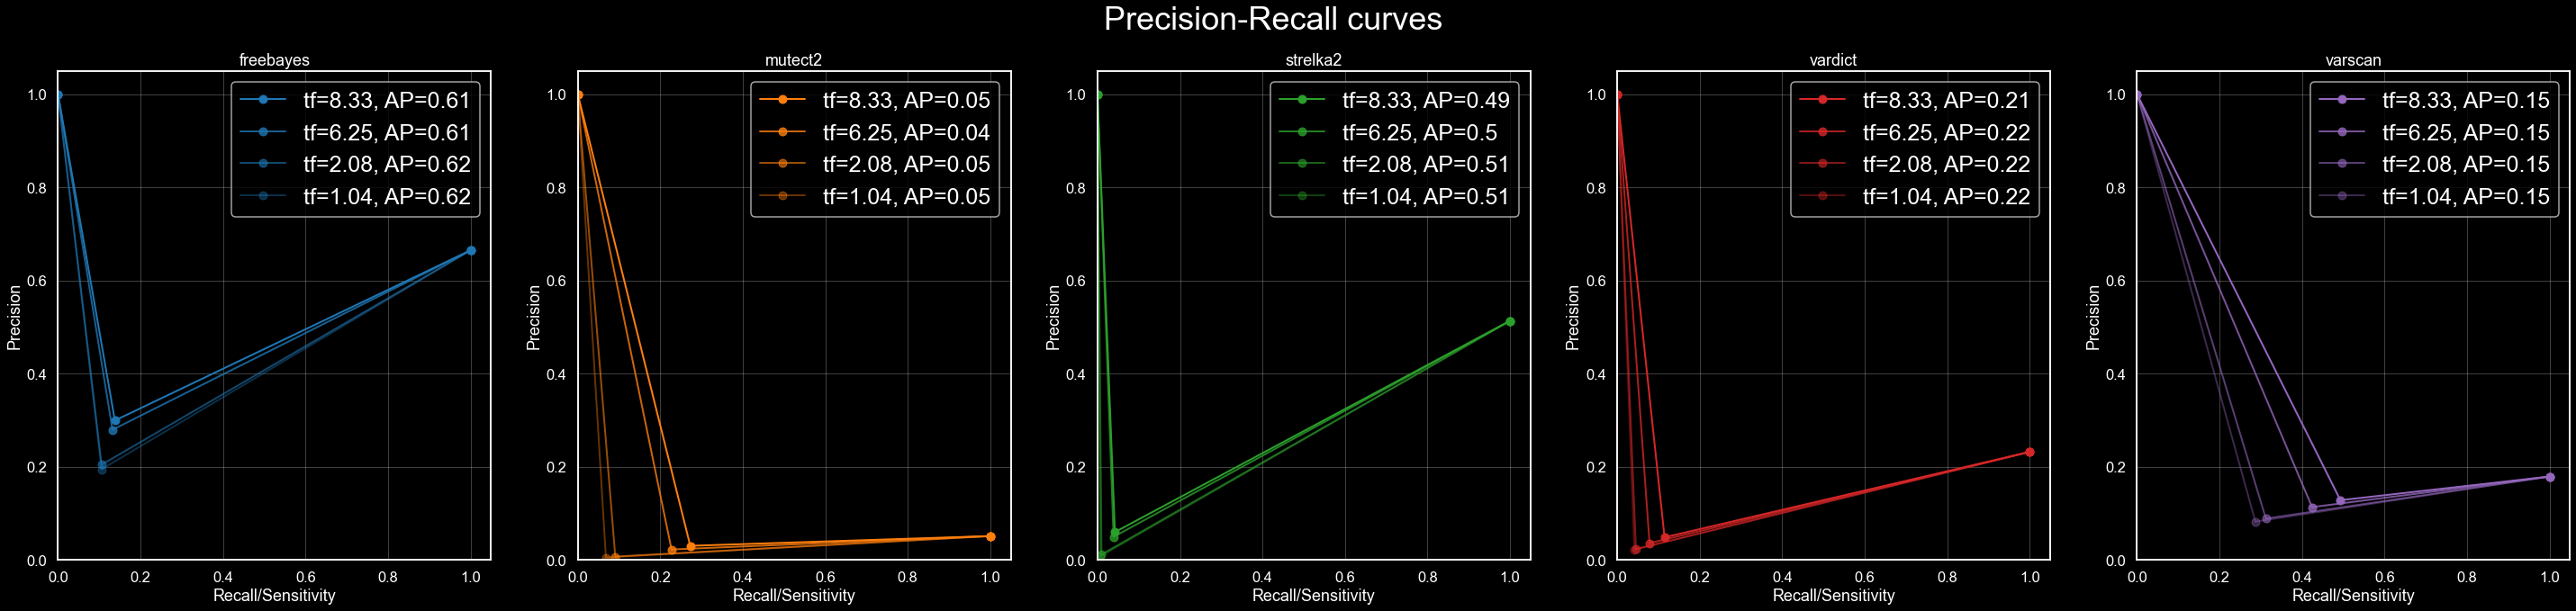

<Figure size 432x288 with 0 Axes>

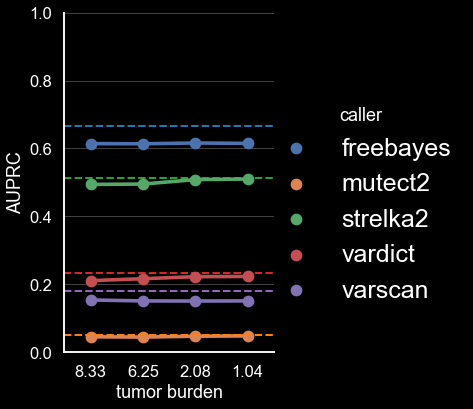

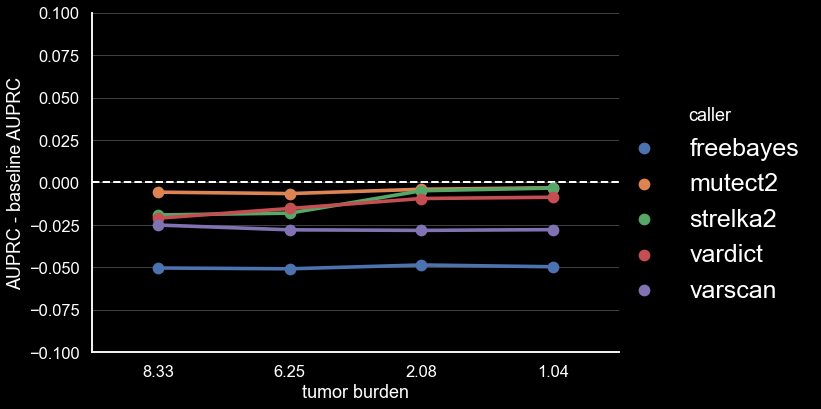

<Figure size 432x288 with 0 Axes>

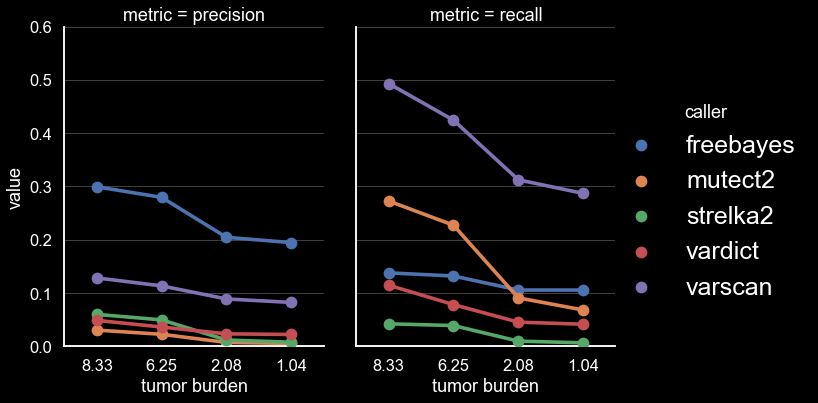

In [49]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            if i == 0:
                si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            else:
                si = sample[['QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            slist.append(si)

        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        
        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall/Sensitivity')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = color_list[mi], linestyle = '--') 
    plt.ylim([0, 1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.6])

In [111]:
for mutation in ['snv']: #, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            if i == 0:
                si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            else:
                si = sample[['QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            slist.append(si)

        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    count = 0

    y_series_list = []

    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)
        
        y_series = pd.concat(y_list[1:], axis=1)
        y_series.insert(0, 'ref', y_true)
        #y_series['ref'] = y_true
        y_series_list.append(y_series.T)
    
    y_series_all = pd.concat(y_series_list, keys=methods)
    #y_series.sort_index(inplace=True)
    #plt.figure()
    #sns.heatmap(y_series, cbar="coolwarm")
    #plt.title(mutation + ' ' + method)
    #plt.show()

In [112]:
y_series_list[0].T

,ref,sample_1,sample_2,sample_3,sample_4
22_16228097,True,False,False,False,False
22_16357562,True,False,False,False,False
22_16549560,True,False,False,False,False
22_16549595,True,True,True,False,False
22_16549601,True,False,False,False,False
...,...,...,...,...,...
22_50769144,False,False,False,True,True
22_51031808,False,False,False,True,True
22_18721083,False,False,False,False,True
22_25107793,False,False,False,False,True


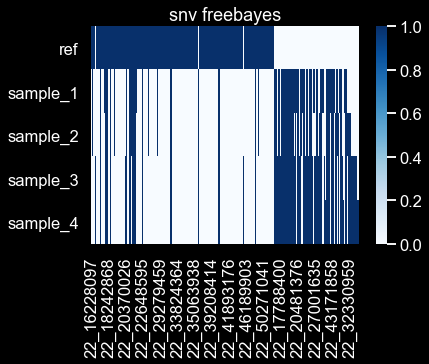

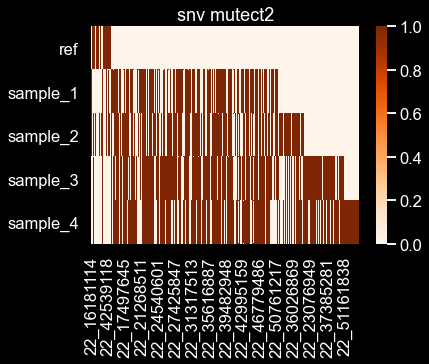

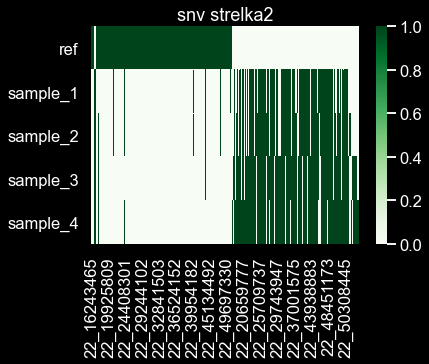

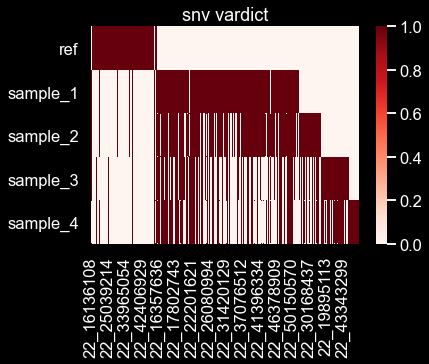

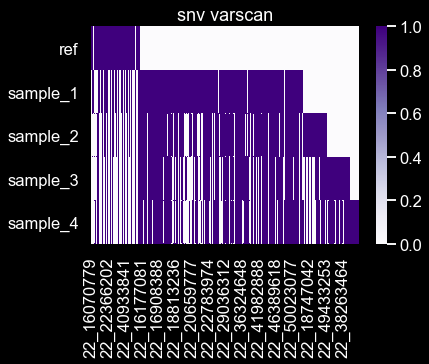

In [113]:
cmap_list=['Blues', 'Oranges', 'Greens', 'Reds', 'Purples']
for i, ys in enumerate(y_series_list):
    plt.figure()
    sns.heatmap(ys, cmap=cmap_list[i])
    plt.title('snv' + ' ' + methods[i])
    plt.show()

<AxesSubplot:>

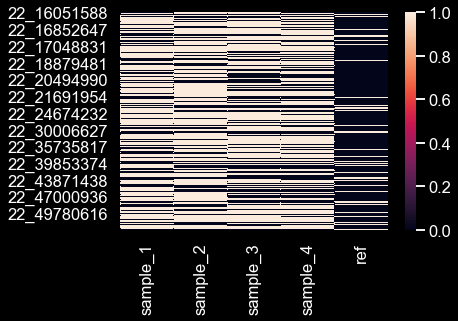

In [114]:
y_true
y_series = pd.concat(y_list[1:], axis=1)
y_series['ref'] = y_true
y_series.sort_index(inplace=True)
sns.heatmap(y_series, cbar="coolwarm")

# Caller robustness (consensus across at least 3 methods) with original Plasma Sample as reference

46906
(52394, 19)


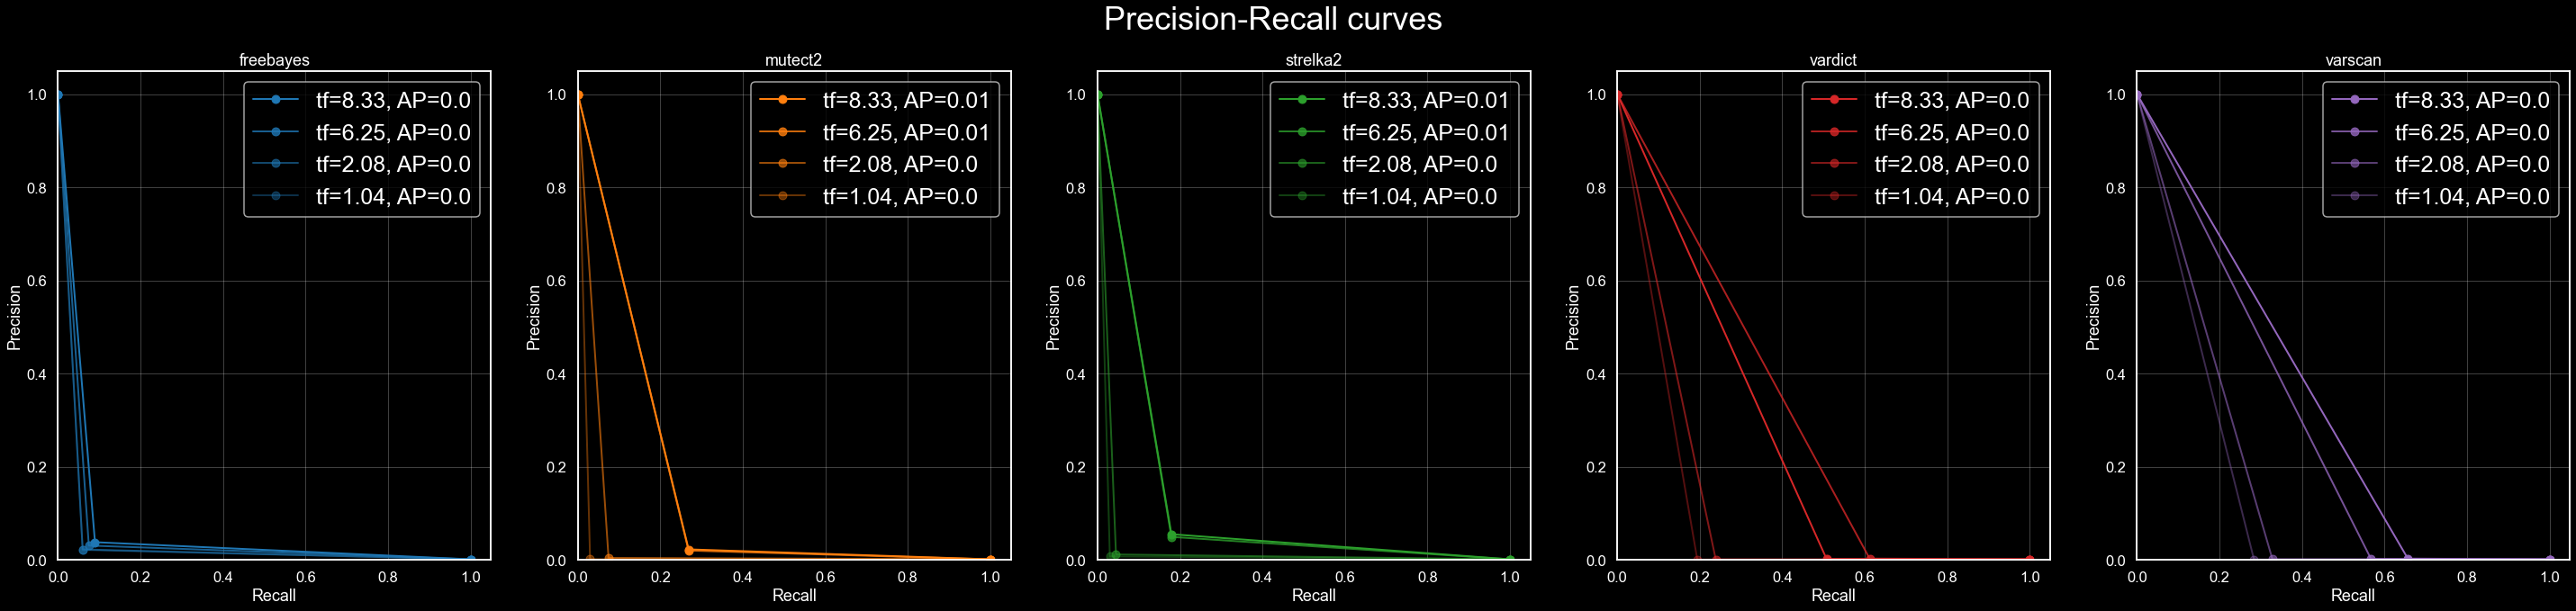

<Figure size 432x288 with 0 Axes>

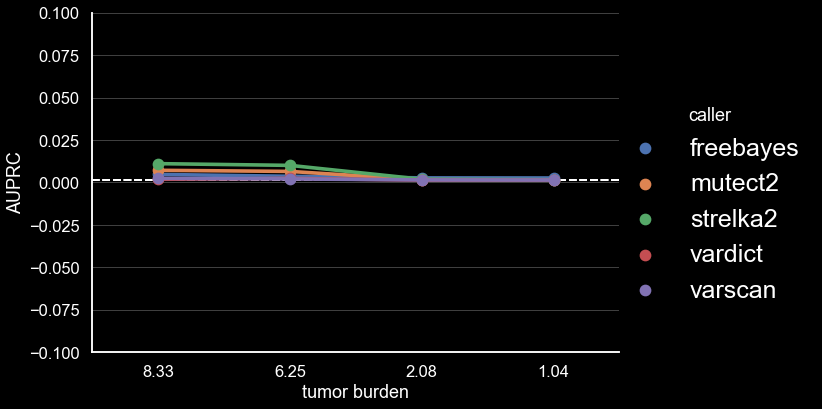

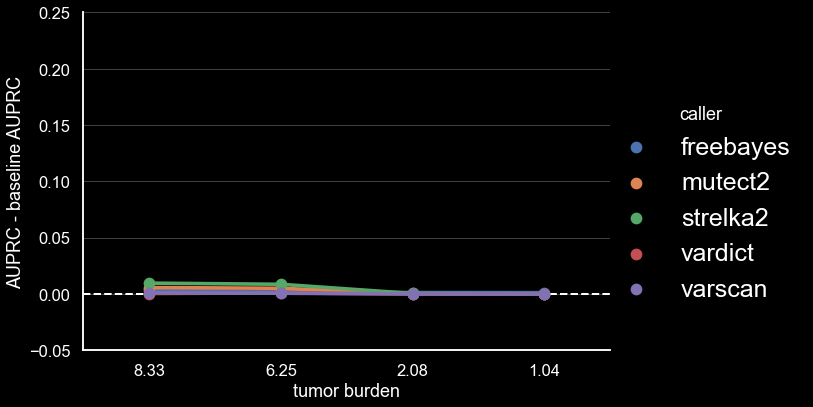

<Figure size 432x288 with 0 Axes>

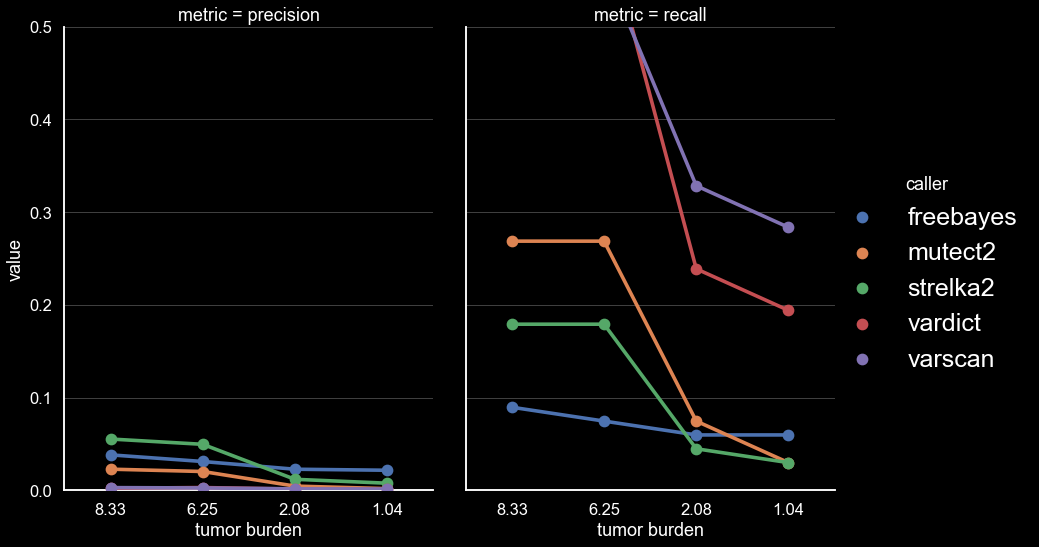

In [52]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            if i == 0:
                si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            else:
                si = sample[['QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            slist.append(si)

        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    
    """nbmin = pd_methods[['QUAL_0', 'caller']].groupby('caller').count().min().values[0]
    print(nbmin)
    y_true = pd_methods[['sample_0', 'QUAL_0', 'caller']]
    y_true.index.name = 'CHROM_POS'
    indexlist = []
    for method in methods:
        a = y_true['QUAL_0'][y_true['caller'] == method].astype(float).nlargest(nbmin)
        indexlist += list(a.index)
        #vprint(len(a))
    indexlist = np.unique(indexlist)"""
    
    
    y_true = pd_methods[['sample_0', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_0'].sum()
    y_true[y_true <= 2] = 0
    #y_true = y_true.loc[indexlist]
    y_true = y_true.astype(bool)
    print(y_true.shape[0])
    print(pd_methods.shape)
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
       # y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([-0.1, 0.1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.05, 0.25])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=8, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.5])

(-0.1, 0.1)

<Figure size 432x288 with 0 Axes>

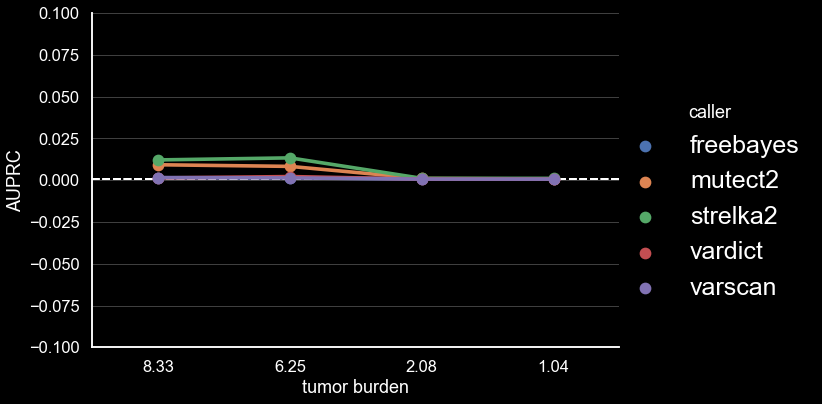

In [51]:
plt.figure()
sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
for mi, method in enumerate(methods):
    plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
plt.ylim([-0.1, 0.1])

# Within caller consistency with both original Plasma Sample as reference

In [74]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        sbis = samples_dict['sample_0_bis'][['REF', 'ALT', 'QUAL', 'type', method]]
        sbis.rename(columns = {method:'sample_0_bis'},  inplace = True)
        sbis = sbis.loc[~sbis.index.duplicated(keep=("first"))]
        slist.append(sbis)
        
        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T
        
        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_0_bis', 'type_0_bis', 'sample_0_bis']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_0_bis'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_0_bis']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        
        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true = pd_methods[pd_methods['caller'] == method][['sample_0', 'sample_0_bis']]
        y_true['ref'] = y_true['sample_0'] & y_true['sample_0_bis']
        y_true.index.name = 'CHROM_POS'
        y_true = y_true.groupby(['CHROM_POS'])['ref'].sum()
        y_true = y_true.astype(bool)
        #y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall/Sensitivity')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = color_list[mi], linestyle = '--') 
    plt.ylim([0, 1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.6])

KeyboardInterrupt: 

# AUPRC with reference = SNV found in both undiluted plasma samples by at least 2 callers

42776
(44714, 25)


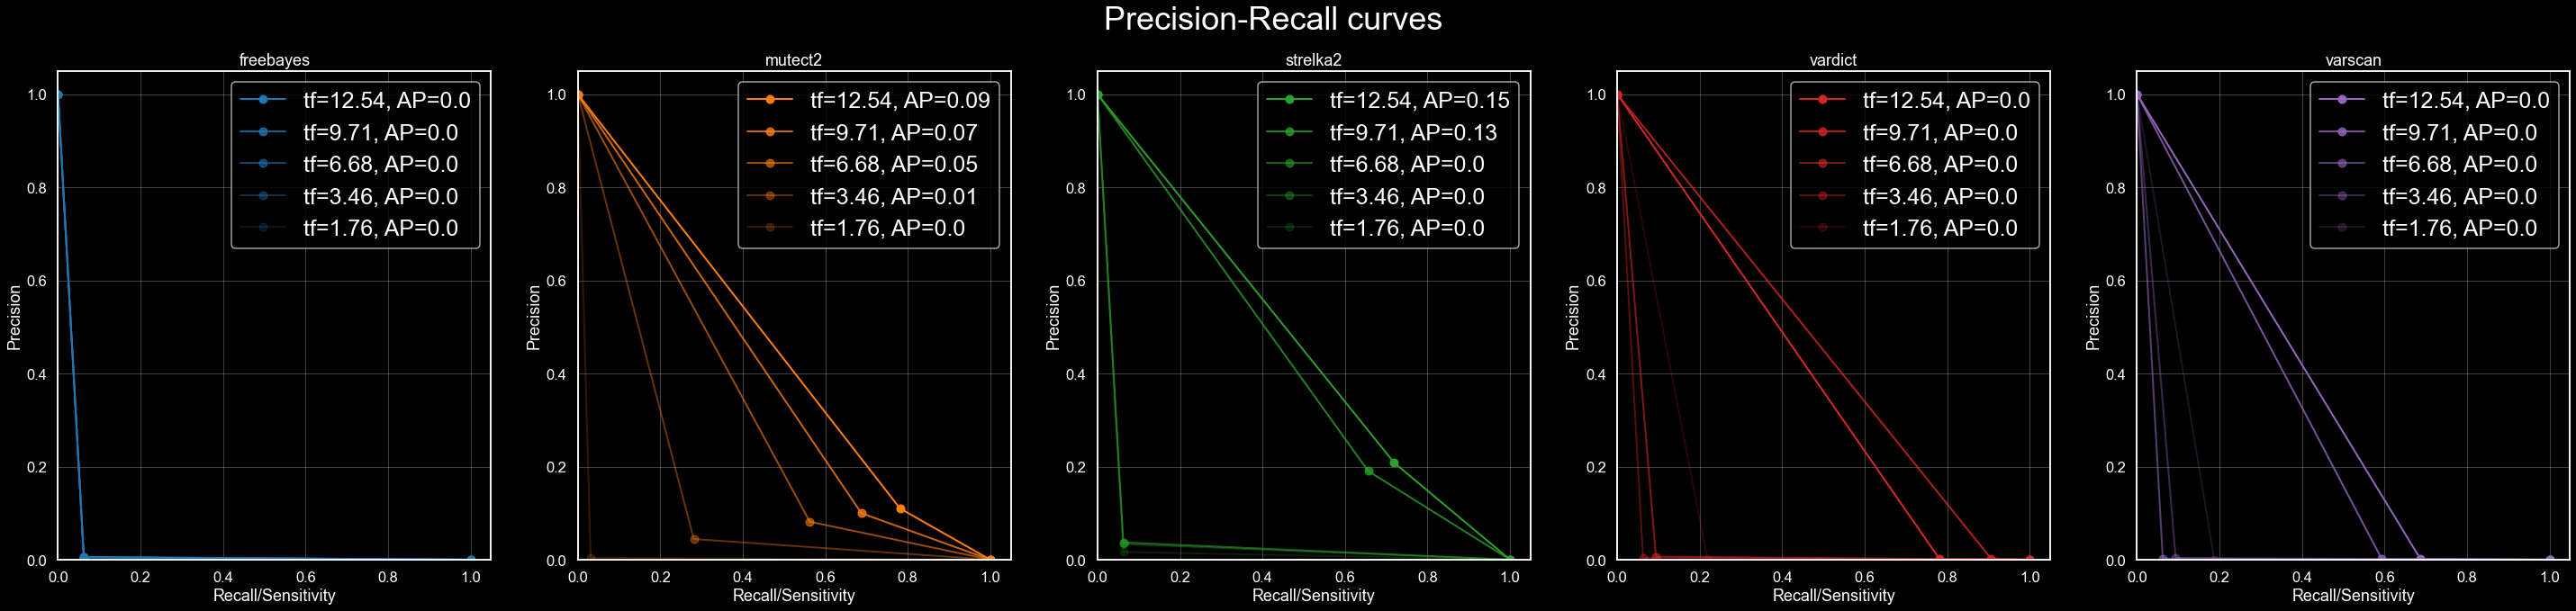

<Figure size 432x288 with 0 Axes>

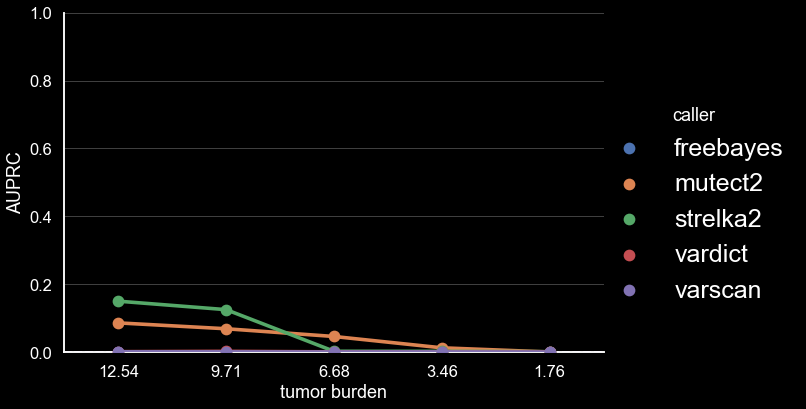

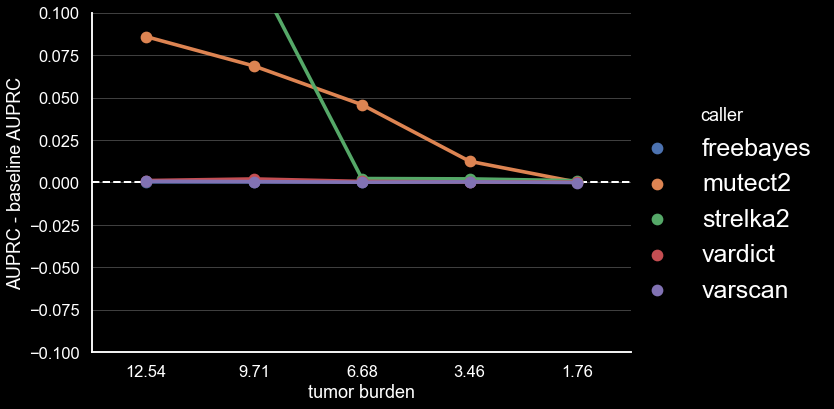

<Figure size 432x288 with 0 Axes>

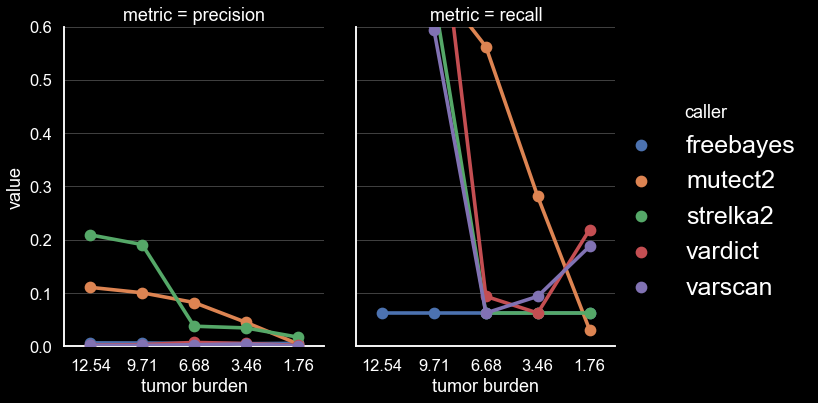

In [76]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        sbis = samples_dict['sample_0_bis'][['REF', 'ALT', 'QUAL', 'type', method]]
        sbis.rename(columns = {method:'sample_0_bis'},  inplace = True)
        sbis = sbis.loc[~sbis.index.duplicated(keep=("first"))]
        slist.append(sbis)
        
        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T
        
        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_0_bis', 'type_0_bis', 'sample_0_bis']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_0_bis']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_0_bis'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_0_bis']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        
        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    
    y_true = pd_methods[['sample_0', 'sample_0_bis', 'caller']]
    y_true['ref'] = pd_methods['sample_0'] & pd_methods['sample_0_bis']
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['ref'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])
    print(pd_methods.shape)
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        #y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall/Sensitivity')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([0, 0.5])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.6])

(0.0, 0.2)

<Figure size 432x288 with 0 Axes>

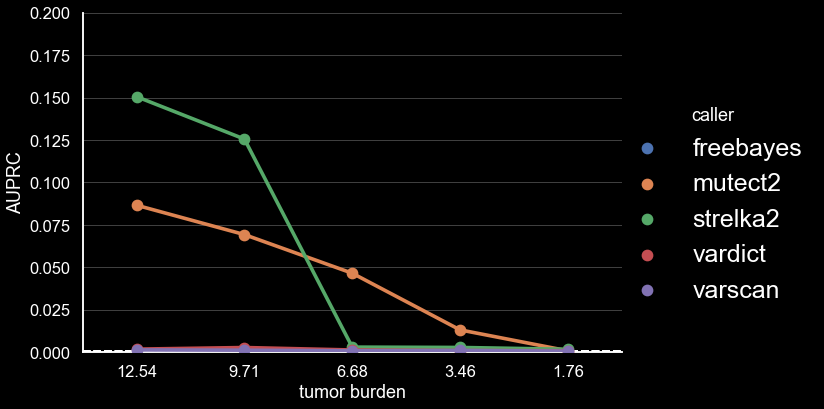

In [80]:
plt.figure()
sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
for mi, method in enumerate(methods):
    plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
plt.ylim([0, 0.2])

## AUPRC with reference = SNV found in the tumor by the same method

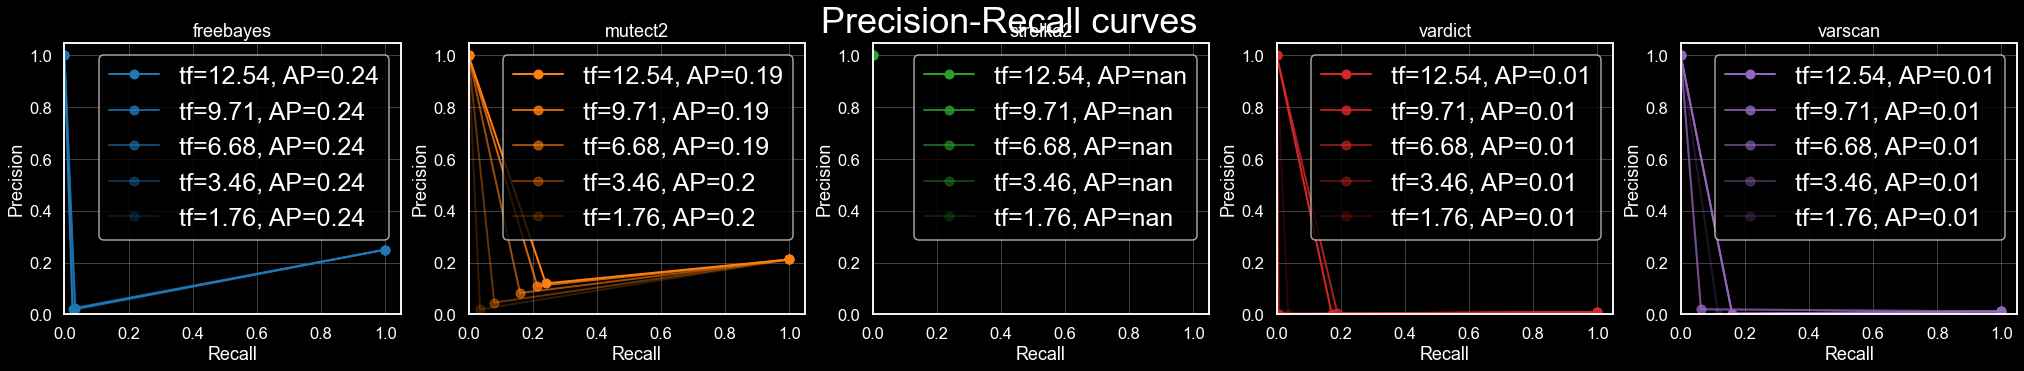

<Figure size 432x288 with 0 Axes>

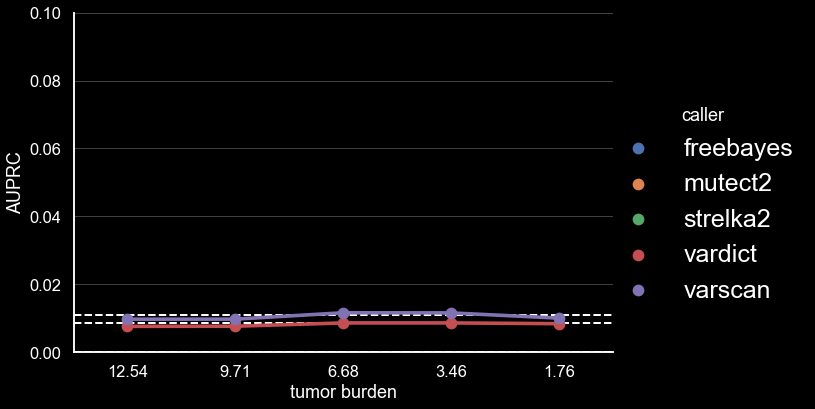

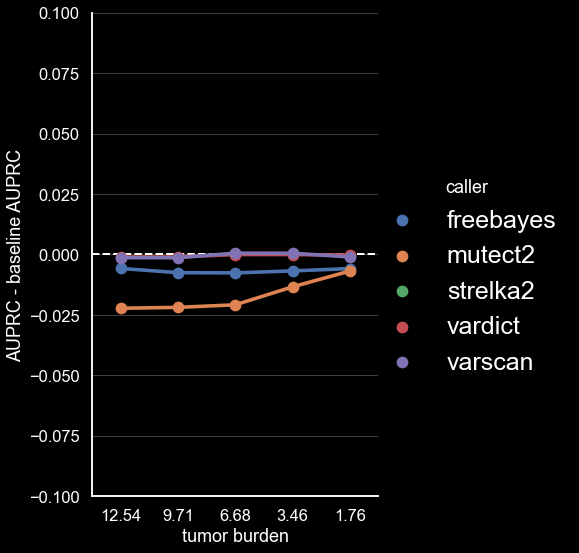

<Figure size 432x288 with 0 Axes>

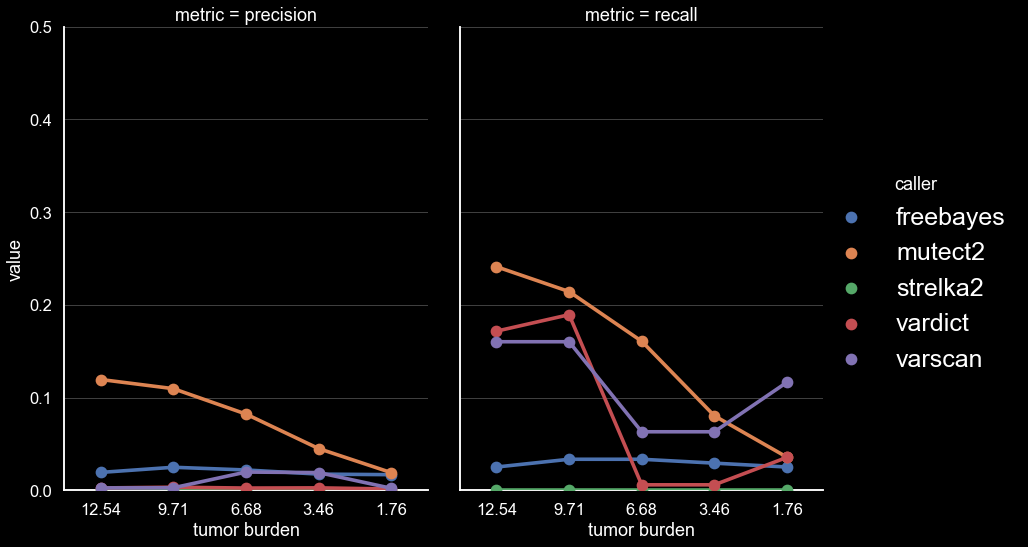

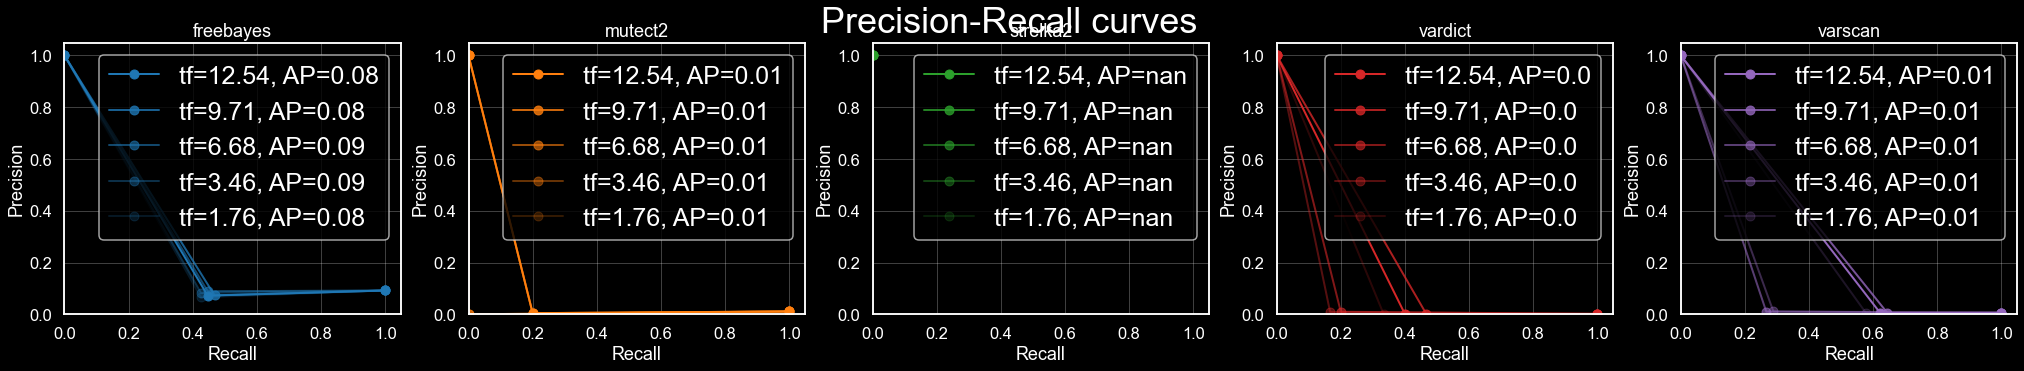

<Figure size 432x288 with 0 Axes>

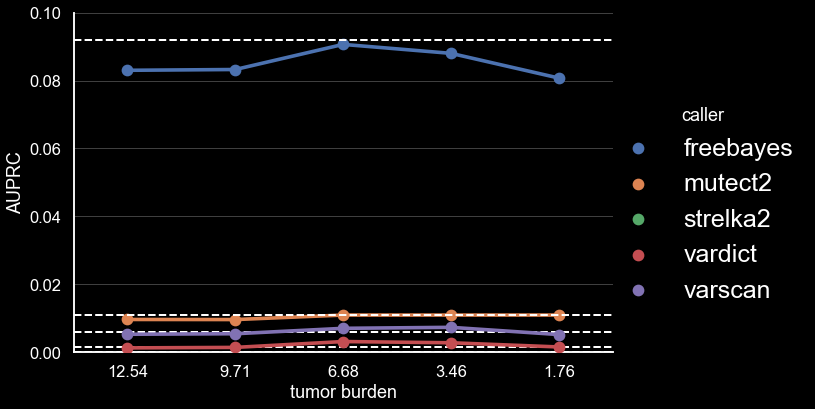

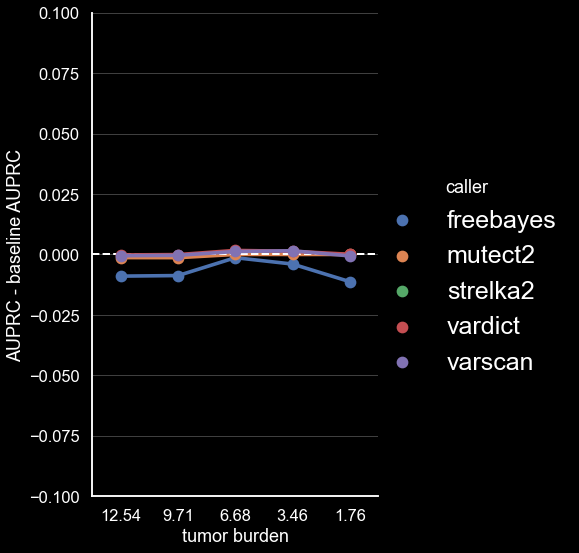

<Figure size 432x288 with 0 Axes>

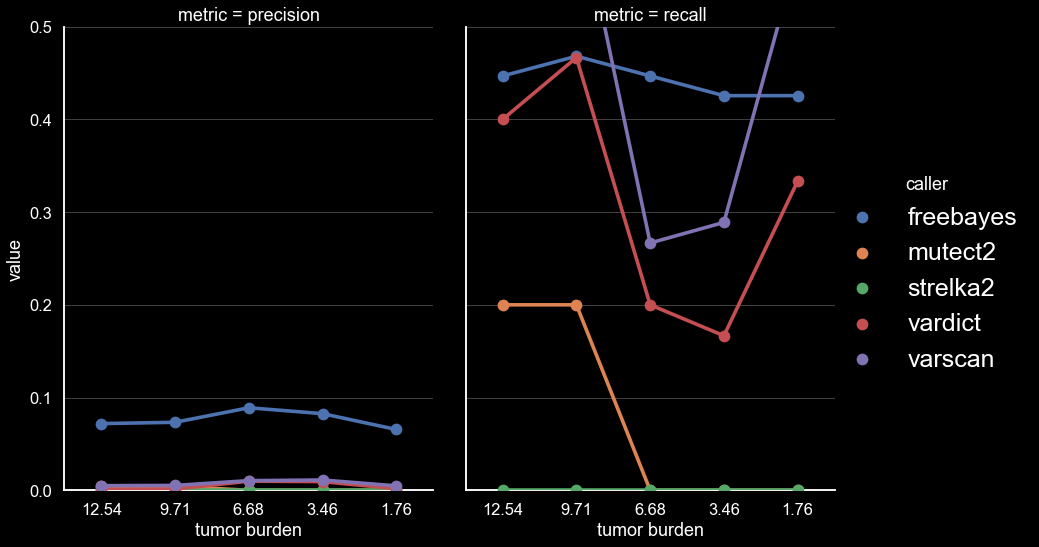

In [81]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        st = samples_dict['sample_t'][['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        st = st.loc[~st.index.duplicated(keep=("first"))]
        slist.append(st)

        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_t', 'type_t', 'sample_t']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_t'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_t']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig.suptitle('Precision-Recall curves')
    

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        y_true = pd_methods[pd_methods['caller'] == method]['sample_t'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([0, 0.1])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=8, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 
    plt.ylim([-0.1, 0.1])

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=8, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.5])

38069


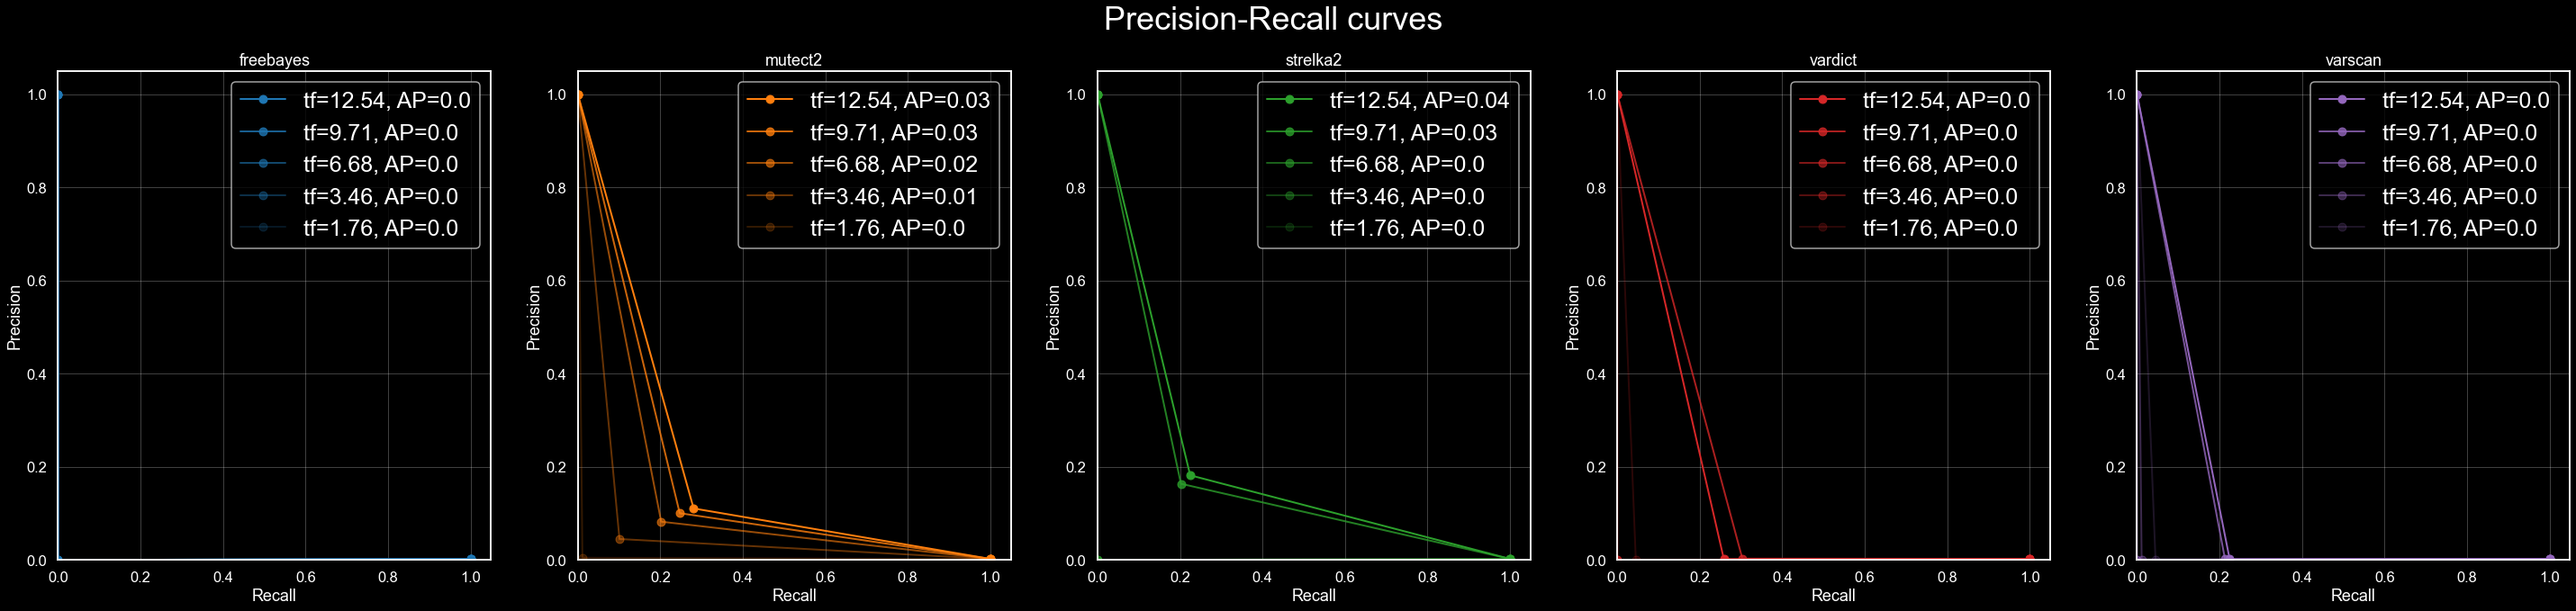

<Figure size 432x288 with 0 Axes>

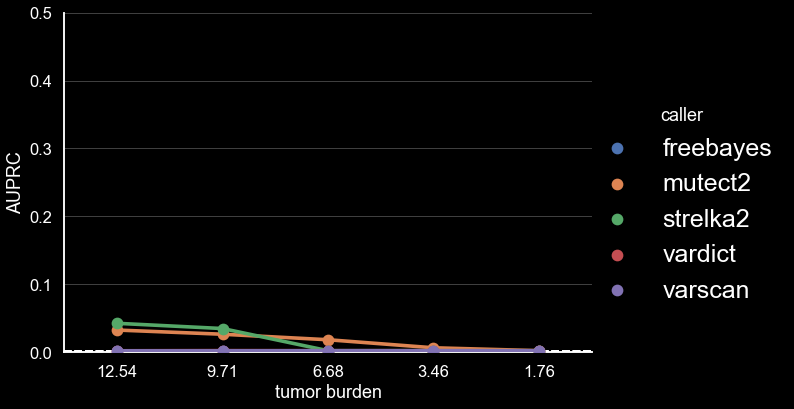

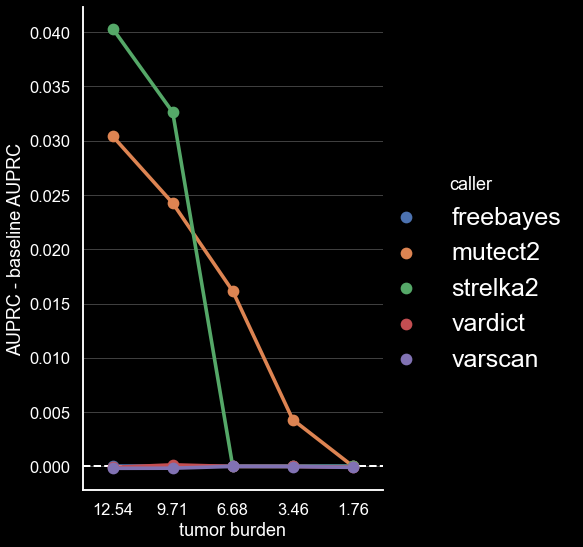

<Figure size 432x288 with 0 Axes>

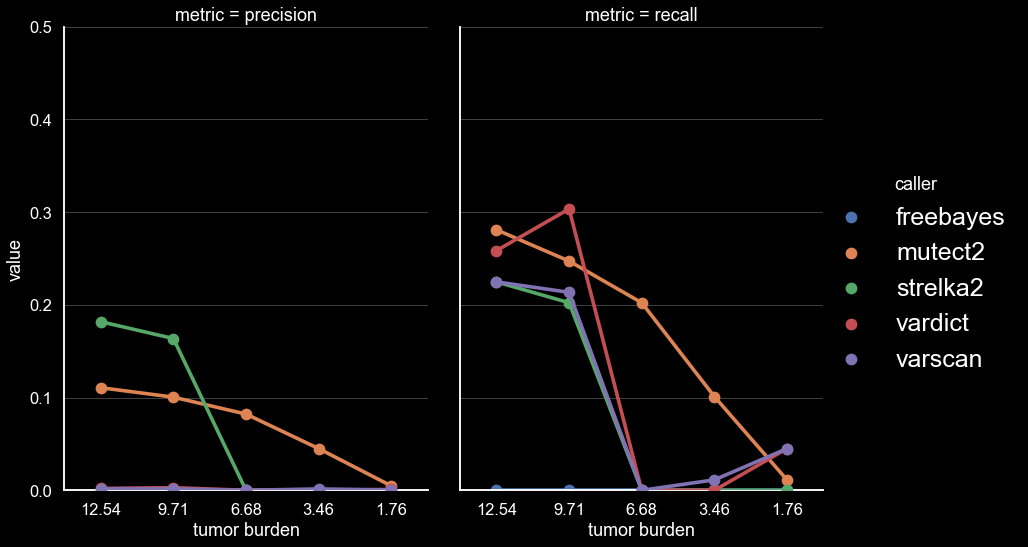

In [20]:
for mutation in ['snv']:#, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            si = si.loc[~si.index.duplicated(keep=("first"))]
            slist.append(si)
        st = samples_dict['sample_t'][['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        st = st.loc[~st.index.duplicated(keep=("first"))]
        slist.append(st)

        pd_method = pd.concat(slist, axis=1)
        #pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_t', 'type_t', 'sample_t']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) + pd_method['sample_t'] == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_t']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    #fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig, axs = plt.subplots(1,nmethods,figsize=(50, 10))
    fig.suptitle('Precision-Recall curves')
    
    y_true = pd_methods[['sample_t', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_t'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=6, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    plt.ylim([0, 0.2])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=8, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=8, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    plt.ylim([0, 0.5])

(0.0, 0.2)

<Figure size 432x288 with 0 Axes>

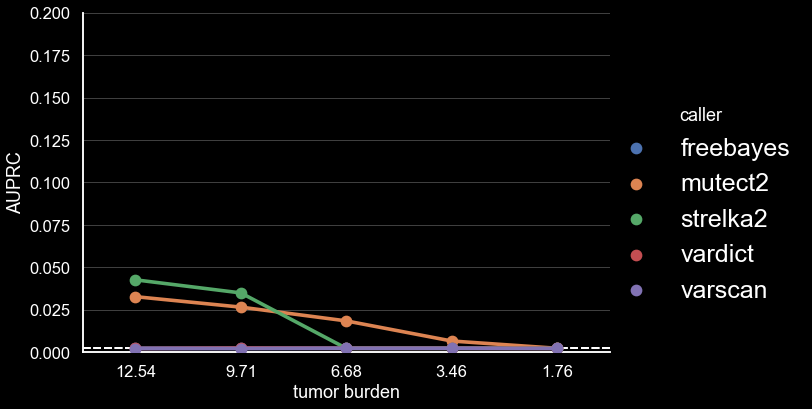

In [21]:
plt.figure()
sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=1.5,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
for mi, method in enumerate(methods):
    plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
plt.ylim([0, 0.2])

In [22]:
for mutation in ['snv']: #, 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']):

        s0 = sample_0[['REF', 'ALT', 'QUAL', 'type', method]]
        s0.rename(columns = {method:'sample_0'},  inplace = True)
        st = sample_t[['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        s1 = sample_1[['REF', 'ALT', 'QUAL', 'type', method]]
        s1.rename(columns = {method:'sample_1'},  inplace = True)
        s2 = sample_2[['REF', 'ALT', 'QUAL', 'type', method]]
        s2.rename(columns = {method:'sample_2'},  inplace = True)
        s3 = sample_3[['REF', 'ALT', 'QUAL', 'type', method]]
        s3.rename(columns = {method:'sample_3'},  inplace = True)
        #s4 = sample_4[['REF', 'ALT', 'QUAL','type', method]]
        #s4.rename(columns = {method:'sample_4'},  inplace = True)
        #s5 = sample_5[['REF', 'ALT', 'QUAL','type', method]]
        #s5.rename(columns = {method:'sample_5'},  inplace = True)

        pd_method = pd.concat([s0.loc[~s0.index.duplicated()],
               st.loc[~st.index.duplicated()],
               s1.loc[~s1.index.duplicated()],
               s2.loc[~s2.index.duplicated()],
               s3.loc[~s3.index.duplicated()],
               s4.loc[~s4.index.duplicated()],
               s5.loc[~s5.index.duplicated()]], axis=1)

        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T
        pd_method.columns = ['REF', 'ALT', 'QUAL_0', 'type_0', 'sample_0','QUAL_t', 'type_t', 'sample_t', 'QUAL_1', 'type_1', 'sample_1', 'QUAL_2', 'type_2', 'sample_2',  'QUAL_3', 'type_3', 'sample_3', 'QUAL_4', 'type_4', 'sample_4', 'QUAL_5', 'type_5', 'sample_5']
        pd_method[['sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']] = pd_method[['sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']].fillna(value=False)
        #pd_method.drop(pd_method[pd_method['sample_0'] + pd_method['sample_0_bis']+ pd_method['sample_1'] + pd_method['sample_2'] + pd_method['sample_3'] + pd_method['sample_4'] == False].index, axis=0, inplace=True)
        pd_method[['REF', 'sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']].head()
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_0','type_t','type_1', 'type_2', 'type_3', 'type_4', 'type_5']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]

        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame.empty
    pd_results_PR = pd.DataFrame.empty
    count = 0

    fig, axs = plt.subplots(1,5,figsize=(30, 4))
    fig.suptitle('Precision-Recall curves')


    y_true = pd_methods[['sample_t', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_t'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])



    baselineAUPRC = {}

    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        #y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool) + pd_methods[pd_methods['caller'] == method]['sample_0_bis'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)

        y_0 = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool).reindex(y_true.index).squeeze()
        y_0 = y_0.fillna(False)
        y_1 = pd_methods[pd_methods['caller'] == method]['sample_1'].astype(bool).reindex(y_true.index).squeeze()
        y_1 = y_1.fillna(False)
        y_2 = pd_methods[pd_methods['caller'] == method]['sample_2'].astype(bool).reindex(y_true.index).squeeze()
        y_2 = y_2.fillna(False)
        y_3 = pd_methods[pd_methods['caller'] == method]['sample_3'].astype(bool).reindex(y_true.index).squeeze()
        y_3 = y_3.fillna(False)
        y_4 = pd_methods[pd_methods['caller'] == method]['sample_4'].astype(bool).reindex(y_true.index).squeeze()
        y_4 = y_4.fillna(False)
        y_5 = pd_methods[pd_methods['caller'] == method]['sample_5'].astype(bool).reindex(y_true.index).squeeze()
        y_5 = y_5.fillna(False)

        res_df['AUPRC'] = [average_precision_score(y_true, y_0),
                          average_precision_score(y_true, y_1),
                          average_precision_score(y_true, y_2),
                          average_precision_score(y_true, y_3),
                          average_precision_score(y_true, y_4),
                          average_precision_score(y_true, y_5),
                         ]
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_0) - baselineAUPRC[method],
                      average_precision_score(y_true, y_1) - baselineAUPRC[method],
                      average_precision_score(y_true, y_2) - baselineAUPRC[method],
                      average_precision_score(y_true, y_3) - baselineAUPRC[method],
                      average_precision_score(y_true, y_4) - baselineAUPRC[method],
                      average_precision_score(y_true, y_5) - baselineAUPRC[method],

                     ]
        res_PR_df['precision'] = [precision_score(y_true, y_0),
                          precision_score(y_true, y_1),
                          precision_score(y_true, y_2),
                          precision_score(y_true, y_3),
                          precision_score(y_true, y_4),
                          precision_score(y_true, y_5),
                         ]

        res_PR_df['recall'] = [recall_score(y_true, y_0),
                          recall_score(y_true, y_1),
                          recall_score(y_true, y_2),
                          recall_score(y_true, y_3),
                          recall_score(y_true, y_4),
                          recall_score(y_true, y_5),
                         ]
        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method
        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, 6], inplace=True)

        # Plot Precision-Recall curve
        alpha_list = [0, 1, .8, .6, .4, .2, .1]
        for i in range(1,6):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=4, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results, legend=False)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    #plt.ylim([0, 0.5])
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 

    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    #plt.ylim([0, 0.5])

NameError: name 'sample_0' is not defined

- Histograms of true allele frequencies in each tumor sample. Note how increasing admixture increases the prevalence of low- frequency variants.
- Benchmarking results for germline SNVs
- Benchmarking results for somatic SNVs on exome data.
- averaged over the four replicates

- add fake mutations on healthy mixtures

In [39]:
cov_pd = pd.read_csv('../data/CRC-986_300316_cov.txt', header=None)
cov_pd.index = [i for i in range(1,1002)]
cov_pd

,0
1,1880935
2,1312716
3,1171549
4,1492055
5,1900432
...,...
997,15728
998,15821
999,16007
1000,16136


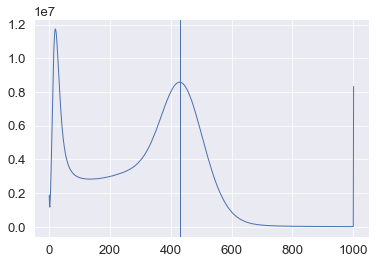

In [52]:
plt.plot(cov_pd.index, cov_pd.values)
plt.axvline(430)

In [43]:
cov_pd.describe()

,0
count,1.001000e+03
mean,2.844013e+06
std,2.883503e+06
min,1.572800e+04
25%,5.442400e+04
50%,2.855419e+06
75%,4.320742e+06
max,1.174217e+07


([<matplotlib.axis.YTick at 0x7fb178a59b50>,
 [Text(0, 0.0, '0'),
  Text(0, 0.1, ''),
  Text(0, 0.2, ''),
  Text(0, 0.30000000000000004, ''),
  Text(0, 0.4, ''),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, ''),
  Text(0, 0.7000000000000001, ''),
  Text(0, 0.8, ''),
  Text(0, 0.9, ''),
  Text(0, 1.0, '1')])

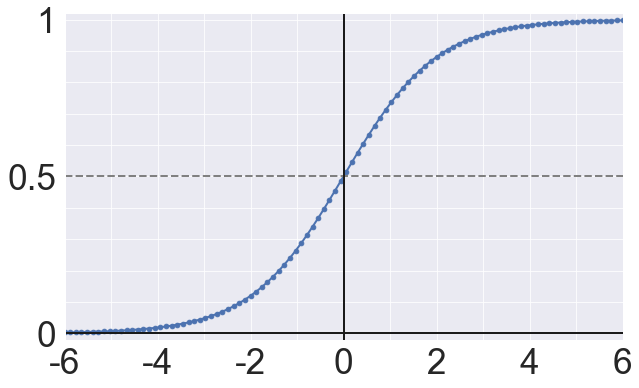

In [102]:
plt.rcParams.update({'font.size': 35})
sns.set(context="paper", font_scale=4, rc={"lines.linewidth": 2, "legend.fontsize":40})
x = np.linspace(-6,6,100)
def sigmoid(z, w, b):
    return 1/(1 + np.exp(-(w*z+b)))
plt.figure(figsize=(10, 6))
plt.scatter(x, sigmoid(x, 1, 0))
plt.plot(x, sigmoid(x, 1, 0)) #, label='w=1, b=0')
#plt.scatter(x, sigmoid(x, 10, 0))
#plt.plot(x, sigmoid(x, 10, 0), lw=2, label='w=10, b=0')
#plt.scatter(x, sigmoid(x, 0.1, 0))
#plt.plot(x, sigmoid(x, 0.1, 0), lw=2, label='w=0.1, b=0')
#plt.plot(x, sigmoid(x, 1, 1), label='w=1, b=1')
#plt.plot(x, sigmoid(x, 1, -1), label='w=1, b=-1')
plt.axhline(0.5, c='grey', ls='--')
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xticks(np.arange(-6, 7, step=1), ['-6', '', '-4', '', '-2', '', '0', '', '2', '', '4', '', '6'])
plt.xlim([-6,6])
plt.ylim([-0.02,1.02])
plt.yticks(np.arange(0, 1.1, step=0.1), ['0', '','','','','0.5', '','','','','1'])
#plt.xlabel('z')
#plt.ylabel('sigma(w.z+b)')
#plt.legend()

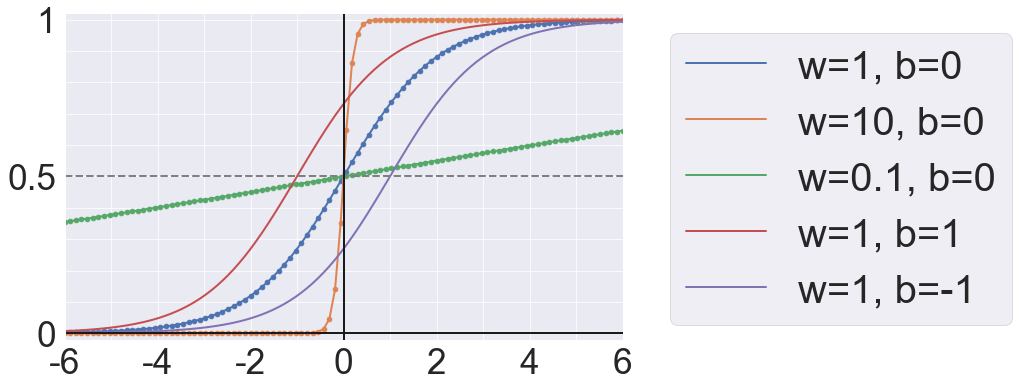

In [109]:
plt.rcParams.update({'font.size': 35})
sns.set(context="paper", font_scale=4, rc={"lines.linewidth": 2, "legend.fontsize":40})
x = np.linspace(-6,6,100)
def sigmoid(z, w, b):
    return 1/(1 + np.exp(-(w*z+b)))
plt.figure(figsize=(10, 6))
plt.scatter(x, sigmoid(x, 1, 0))
plt.plot(x, sigmoid(x, 1, 0), label='w=1, b=0')
plt.scatter(x, sigmoid(x, 10, 0))
plt.plot(x, sigmoid(x, 10, 0), label='w=10, b=0')
plt.scatter(x, sigmoid(x, 0.1, 0))
plt.plot(x, sigmoid(x, 0.1, 0),  label='w=0.1, b=0')
plt.plot(x, sigmoid(x, 1, 1), label='w=1, b=1')
plt.plot(x, sigmoid(x, 1, -1), label='w=1, b=-1')
plt.axhline(0.5, c='grey', ls='--')
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xticks(np.arange(-6, 7, step=1), ['-6', '', '-4', '', '-2', '', '0', '', '2', '', '4', '', '6'])
plt.xlim([-6,6])
plt.ylim([-0.02,1.02])
plt.yticks(np.arange(0, 1.1, step=0.1), ['0', '','','','','0.5', '','','','','1'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

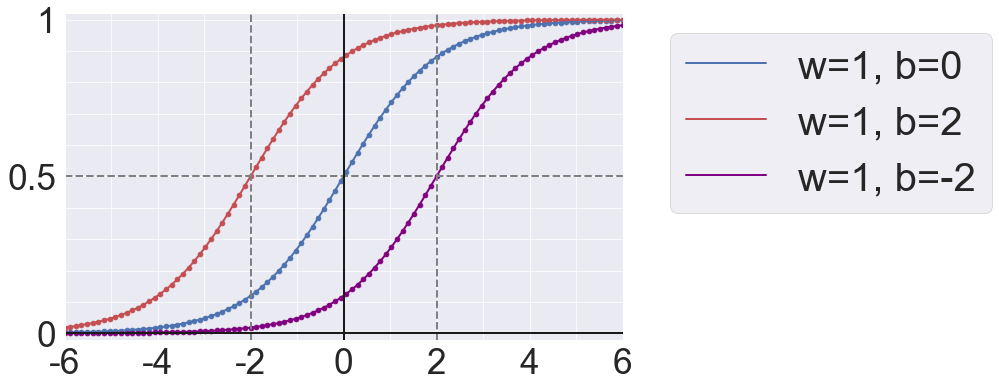

In [115]:
plt.rcParams.update({'font.size': 35})
sns.set(context="paper", font_scale=4, rc={"lines.linewidth": 2, "legend.fontsize":40})
x = np.linspace(-6,6,100)
def sigmoid(z, w, b):
    return 1/(1 + np.exp(-(w*z+b)))
plt.figure(figsize=(10, 6))
plt.scatter(x, sigmoid(x, 1, 0))
plt.plot(x, sigmoid(x, 1, 0), label='w=1, b=0')
plt.scatter(x, sigmoid(x, 1, 2), c='r')
plt.plot(x, sigmoid(x, 1, 2), label='w=1, b=2', c='r')
plt.scatter(x, sigmoid(x, 1, -2), c='purple')
plt.plot(x, sigmoid(x, 1, -2), label='w=1, b=-2', c='purple')
plt.axhline(0.5, c='grey', ls='--')
plt.axvline(-2, c='grey', ls='--')
plt.axvline(2, c='grey', ls='--')
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xticks(np.arange(-6, 7, step=1), ['-6', '', '-4', '', '-2', '', '0', '', '2', '', '4', '', '6'])
plt.xlim([-6,6])
plt.ylim([-0.02,1.02])
plt.yticks(np.arange(0, 1.1, step=0.1), ['0', '','','','','0.5', '','','','','1'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')